#Prepared by Tamal Acharya

#Agentic RAG Project Overview

Let me walk you through what we’re building step by step. It’s all about creating a RAG pipeline based on the architecture shown here:

Image credit/source: DataCamp

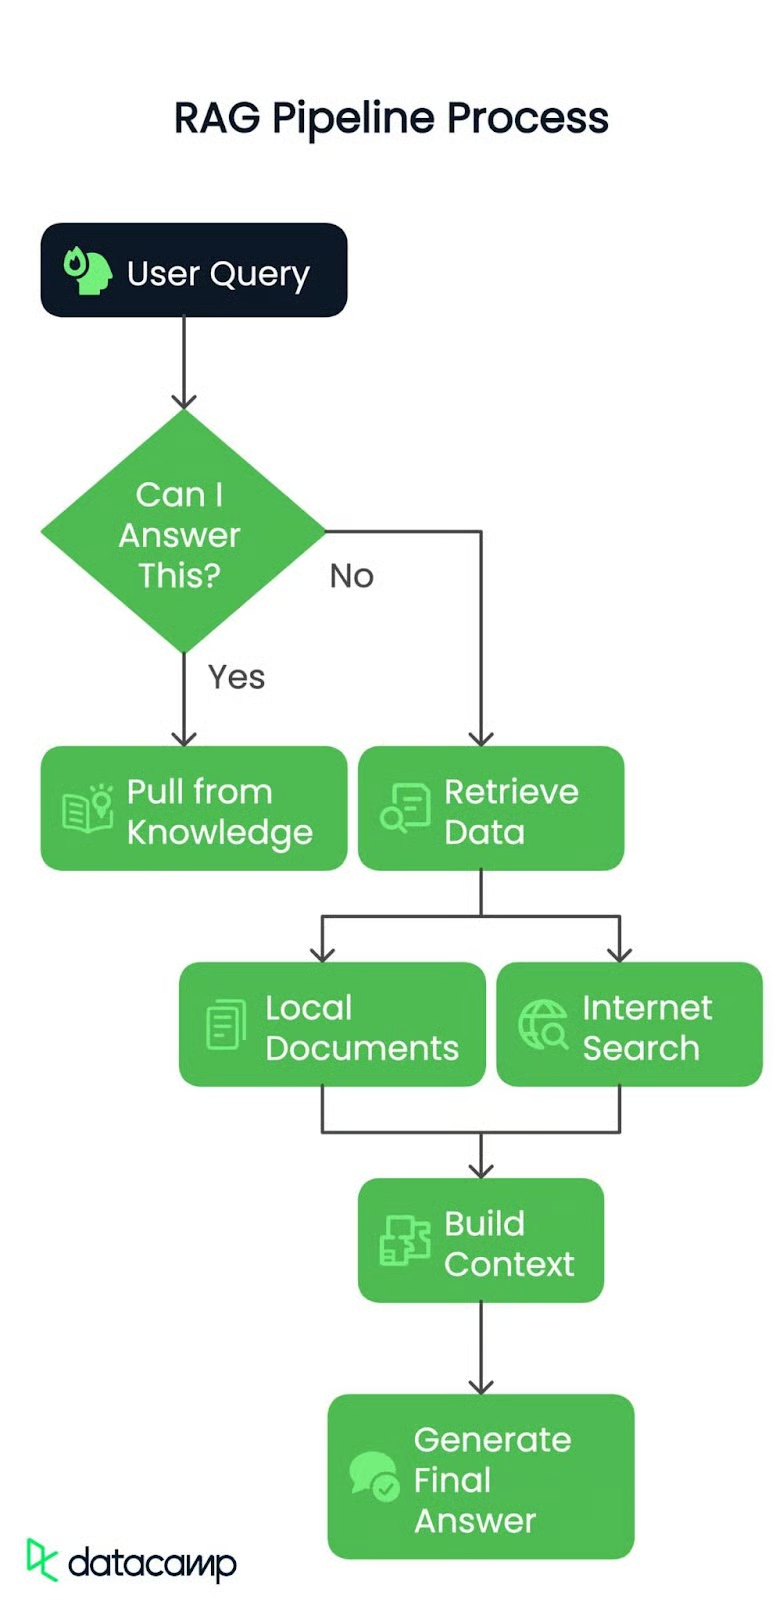

Step 1: User query

Whether it’s a simple query or a complex problem, it all starts with a question from the user. This is the spark that sets our pipeline in motion.

Step 2: Routing the query

Next, the system checks: Can I answer this?

Yes? It pulls from existing knowledge and delivers the response immediately.

No? Time to dig deeper! The query gets routed to the next step.

Step 3: Retrieving the data

If the answer isn’t readily available, the pipeline dives into two possible sources:

  1. Local documents: We’ll use a pre-processed PDF as our knowledge base, where the system searches for relevant chunks of information.

  2. Internet search: If more context is needed, the pipeline can reach out to external sources to scrape up-to-date information.

Step 4: Building the context

The retrieved data whether from the PDF or the web, is then compiled into a coherent, retrieved context. Think of it as gathering all the puzzle pieces before putting them together.

Step 5: Final answer generation

Finally, this context is passed to a large language model (LLM) to craft a clear and accurate answer. It’s not just about retrieving data, it’s about understanding and presenting it in the best possible way.

#Local Data Source
https://www.cmu.edu/intelligentbusiness/expertise/genai-principles.pdf


We are going to use a real-world document as our local data source. The document we’ll work with is Generative AI Principles (link given above). We would also need a summary of the file which we are using for routing purposes. You can get the summary below. Copy that ina  text file and anme it file_summary.txt and keep it ready.

#File Summary

Detailed Summary of the "Generative AI Principles" Document. You can refer the below docs for the following things:
The document provides an in-depth exploration of generative artificial intelligence (GenAI), focusing on the principles, functionality, and advancements of large language models (LLMs). Below is a concise but detailed summary of the key points covered:

Introduction to Generative AI
Generative AI refers to advanced algorithms capable of creating novel content, such as text, audio, video, images, and code, based on user prompts. Recent breakthroughs in machine learning, massive datasets, and computational power have propelled GenAI tools to achieve near-human-level performance in professional and academic benchmarks. These tools have revolutionized industries by enhancing business operations and enabling new possibilities that were previously impractical.

Purpose and Scope
The document addresses key questions about GenAI, such as its functionality, differences from traditional AI models, impactful tasks, and future advancements. While primarily focused on large language models (LLMs), it also highlights successful applications in other modalities, such as image and code generation, as seen with tools like Adobe’s visual content generators and GitHub Copilot.

Functionality of Language Models  
At their core, language models predict the next word (or token) in a sequence based on context. This stochastic process ensures variability in generated responses and demonstrates the importance of well-crafted prompts. Prompt engineering and breaking down tasks into subproblems can significantly improve outcomes. The document also notes that modern LLMs maintain coherence even when generating extensive text.

Key AI Advancements Underpinning LLMs  
1. Classical Machine Learning: Traditional supervised learning relied on labeled data to create predictive models. However, its performance was constrained by the quality of curated datasets and handcrafted representations.  
2. Deep Learning Revolution: Deep neural networks automated representation learning, using hierarchical layers to extract meaningful features from raw data. This innovation spurred progress in image, speech, and text processing.  
3. Word Embeddings: The introduction of models like Word2Vec demonstrated that unstructured textual data could be used to derive semantically rich vector representations without manual labeling.  
4. Transformers: The 2017 introduction of the transformer architecture enabled efficient processing of long-range relationships within text, overcoming limitations of earlier recurrent neural networks (RNNs). This laid the groundwork for models like GPT-3, which leverage massive datasets and billions of parameters.

Paradigm Shifts in LLMs  
Modern LLMs like GPT-3 introduced a shift from supervised fine-tuning to in-context learning, allowing users to provide examples in prompts without requiring model retraining. This democratized access to LLMs, as users could adapt models to specific tasks without computationally intensive fine-tuning.

Aligning LLMs with User Needs  
OpenAI’s InstructGPT model improved alignment with user instructions by combining supervised learning on human-labeled data with reinforcement learning from human feedback. This alignment addressed shortcomings in earlier models, such as their tendency to generate irrelevant or incorrect outputs.

The Future of Generative AI  
The concept of foundation models extends beyond language to other domains, aiming to create general-purpose AI systems capable of supporting diverse applications. The document envisions such models transforming industries by amortizing the cost of learning across tasks and domains.

Conclusion  
The document situates GenAI and LLMs within the broader AI landscape, highlighting their advantages, limitations, and transformative potential. It emphasizes the trade-offs between computational resources and performance, advocating for informed use of these technologies to maximize their benefits.

##Prerequisites

Before we dive in, there are a couple of things you’ll need to have in place:

1. Groq API key: You’ll need an API key from Groq, which you can grab from here: Groq API Console https://console.groq.com/keys

2. Gemini API key: Gemini will help you when orchestrating with agents, Groq gives super fast responses but might get stuck with the current rate limits they have: Gemini API Console https://aistudio.google.com/apikey

3. Serper.dev API key: For any internet search functionality, we’ll use Serper.dev. Get your API key here: Serper.dev API Key https://serper.dev/api-key

In [ ]:
#Installing Packages
!pip install langchain-groq faiss-cpu crewai google-search-results pypdf2 python-dotenv setuptools sentence-transformers huggingface langchain-community crewai_tools

al/lib/python3.11/dist-packages (from onnxruntime==1.22.0->crewai) (1.13.1)


In [ ]:
#Setting Up the Environment
import os
from dotenv import load_dotenv
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from crewai_tools import SerperDevTool, ScrapeWebsiteTool
from crewai import Agent, Task, Crew, LLM
from google.colab import userdata

# Load environment variables from .env file (if it exists)
load_dotenv()

# Get API keys from Colab Secrets
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
SERPER_API_KEY = userdata.get('SERPER_API_KEY')
GEMINI = userdata.get('GEMINI')

# Explicitly set environment variables for libraries that might not use userdata
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["SERPER_API_KEY"] = SERPER_API_KEY
os.environ["GEMINI"] = GEMINI

We start by initializing two language models:

1. llm: For general tasks like routing and generating answers. We’ll use the llama-3.3-70b-specdec model.

2. crew_llm: Specifically for the web-scraping agent, as it needs a slightly different configuration (like temperature for more creative outputs). We’ll use the gemini/gemini-1.5-flash model.

In [ ]:
#Initializing the LLMs
# Initialize LLM
llm = ChatGroq(
    api_key=GROQ_API_KEY,
    model="llama3-8b-8192",
    temperature=0,
    max_tokens=500,
    timeout=None,
    max_retries=2,
)

crew_llm = LLM(
    model="gemini/gemini-1.5-flash",
    api_key=GEMINI,
    max_tokens=500,
    temperature=0.7
)

In [ ]:
#Adding the Decision Maker
def check_local_knowledge(query, context):
    """Router function to determine if we can answer from local knowledge"""
    prompt = '''Role: Question-Answering Assistant
Task: Determine whether the system can answer the user's question based on the provided text.
Instructions:
    - Analyze the text and identify if it contains the necessary information to answer the user's question.
    - Provide a clear and concise response indicating whether the system can answer the question or not.
    - Your response should include only a single word. Nothing else, no other text, information, header/footer.
Output Format:
    - Answer: Yes/No
Study the below examples and based on that, respond to the last question.
Examples:
    Input:
        Text: The capital of France is Paris.
        User Question: What is the capital of France?
    Expected Output:
        Answer: Yes
    Input:
        Text: The population of the United States is over 330 million.
        User Question: What is the population of China?
    Expected Output:
        Answer: No
    Input:
        User Question: {query}
        Text: {text}
'''
    formatted_prompt = prompt.format(text=context, query=query)
    response = llm.invoke(formatted_prompt)
    return response.content.strip().lower() == "yes"

Next, we set up a web searching and scraping agent using the crewai library. This agent uses a search tool (SerperDevTool) to find articles related to the user’s query. The task description ensures the agent knows what to retrieve, and it summarizes the relevant web content. It’s like sending a specialized worker to fetch data from the internet.

Then, the get_web_content() function runs the web scraping agent. It sends the query as input and retrieves a concise summary of the most relevant article. It returns the raw result, which becomes our context if the router decides we don’t have enough local information.

In [ ]:
#Web Searching and Scraping Agent
def setup_web_scraping_agent():
    """Setup the web scraping agent and related components"""
    search_tool = SerperDevTool()  # Tool for performing web searches
    scrape_website = ScrapeWebsiteTool()  # Tool for extracting data from websites

    # Define the web search agent
    web_search_agent = Agent(
        role="Expert Web Search Agent",
        goal="Find the most relevant web page URL for the given topic.",
        backstory="An expert in using search engines to find pertinent information quickly and efficiently.",
        allow_delegation=False,
        verbose=True, # Keep agent verbosity for now
        llm=crew_llm,
        tools=[search_tool] # Assign the tool directly to the agent
    )

    # Define the web scraping agent
    web_scraper_agent = Agent(
        role="Expert Web Scraper Agent",
        goal="Given a URL, extract and summarize the main content from the website.",
        backstory="A skilled web scraper capable of accurately extracting and summarizing information from web pages based on provided URLs.",
        allow_delegation=False,
        verbose=True, # Keep agent verbosity for now
        llm=crew_llm,
        tools=[scrape_website] # Assign the tool directly to the agent
    )

    # Define the web search task - focus on getting a single relevant URL
    search_task = Task(
        description=(
            "Search the web for information on '{topic}' and identify the single most relevant web page. "
            "Provide ONLY the URL of that page as your final answer." # Simplify to one URL
        ),
        expected_output=(
            "The URL of the single most relevant web page for the topic '{topic}'. Example:\n"
            "http://example.com/most_relevant_page"
        ),
        agent=web_search_agent,
        # tools are assigned to the agent, not the task
    )

    # Define the web scraping task - takes URL from the search task
    # Modify description to reference the output of the previous task
    scraping_task = Task(
        description=(
            "Scrape and summarize the content from the URL provided by the previous task, which is relevant to '{topic}'. "
            "The URL will be provided as the context of this task. "
            "Extract the main content and provide a concise summary of the key insights from the URL."
        ),
        expected_output=(
            "A detailed summary of the content from the provided URL, highlighting the key insights "
            "and explaining their relevance to the topic: '{topic}'. Format the output clearly, "
            "mentioning the source URL."
        ),
        agent=web_scraper_agent,
        context=[search_task] # The output of search_task is the context for this task
        # tools are assigned to the agent, not the task
    )

    # Define the crew to manage agents and tasks
    crew = Crew(
        agents=[web_search_agent, web_scraper_agent],
        tasks=[search_task, scraping_task],
        verbose=0, # Reduce crew verbosity to 0
        memory=False,
    )
    return crew

def get_web_content(query):
    """Get content from web scraping"""
    crew = setup_web_scraping_agent()
    # Pass the topic as input to the kickoff method.
    # CrewAI is expected to manage the task dependencies and pass the output of search_task
    # as context to scraping_task automatically.
    result = crew.kickoff(inputs={"topic": query})
    return result

The setup_vector_db() function sets up the vector database from a PDF file. Here’s how I did it step by step:

1. Load the PDF: I used PyPDFLoader to extract the content.

2. Chunk the text: I split the PDF content into smaller chunks (1000 characters with 50 characters overlap) using RecursiveCharacterTextSplitter. This makes the data manageable and searchable.

3. Create Vector DB: I embedded the chunks using a sentence-transformer model and stored them in a FAISS vector database. This lets me search for relevant text efficiently.

After that, the get_local_content() function queries the vector database for the top 5 most relevant chunks related to the user’s query. It combines these chunks into a single string of context.

In [ ]:
#Creating the Vector Database
def setup_vector_db(pdf_path):
    """Setup vector database from PDF"""
    # Load and chunk PDF
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=50
    )
    chunks = text_splitter.split_documents(documents)

    # Create vector database
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-mpnet-base-v2"
    )
    vector_db = FAISS.from_documents(chunks, embeddings)

    return vector_db

def get_local_content(vector_db, query):
    """Get content from vector database"""
    docs = vector_db.similarity_search(query, k=5)
    return " ".join([doc.page_content for doc in docs])

Once I have the context (from either local documents or web scraping), I pass it to the language model along with the user’s query. The LLM generates the final answer by combining both the context and query in a conversational format.

Here’s the flow of the main query processing:

1. Routing: I use check_local_knowledge() to decide if the local PDF content has enough data to answer the query.

    1. If "Yes", I fetch relevant chunks from the vector database.

    2. If "No", I scrape the web for relevant articles.

Final Answer: Once I have the context, I pass it to the LLM to generate the final response.

In [ ]:
#Generating the Final Answer
def generate_final_answer(context, query):
    """Generate final answer using LLM"""
    messages = [
        (
            "system",
            "You are a helpful assistant. Use the provided context to answer the query accurately.",
        ),
        ("system", f"Context: {context}"),
        ("human", query),
    ]
    response = llm.invoke(messages)
    return response.content

def process_query(query, vector_db, local_context):
    """Main function to process user query"""
    print(f"Processing query: {query}")

    # Step 1: Check if we can answer from local knowledge
    can_answer_locally = check_local_knowledge(query, local_context)
    print(f"Can answer locally: {can_answer_locally}")

    # Step 2: Get context either from local DB or web
    if can_answer_locally:
        context = get_local_content(vector_db, query)
        print("Retrieved context from local documents")
    else:
        context = get_web_content(query)
        print("Retrieved context from web scraping")

    # Step 3: Generate final answer
    answer = generate_final_answer(context, query)
    return answer

Lastly, we tie everything together with the main() function:

In [ ]:
def main():
    # Setup
    pdf_path = "/content/genai-principles.pdf"

    # Initialize vector database
    print("Setting up vector database...")
    vector_db = setup_vector_db(pdf_path)

    # Get initial context from PDF for routing
    local_context = get_local_content(vector_db, "")

    # Example usage
    query = "What is Agentic RAG?"
    result = process_query(query, vector_db, local_context)
    print("\nFinal Answer:")
    print(result)
if __name__ == "__main__":
    main()

Setting up vector database...
Processing query: What is Agentic RAG?
Can answer locally: False
# Agent: Expert Web Search Agent
## Task: Search the web for information on 'What is Agentic RAG?' and identify the single most relevant web page. Provide ONLY the URL of that page as your final answer.


# Agent: Expert Web Search Agent
## Thought: tool_code
Thought: I need to search the internet for information on "What is Agentic RAG?" to find the most relevant webpage.  I will use the Serper tool for this.
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_query\": \"What is Agentic RAG?\"}"
## Tool Output: 
{'searchParameters': {'q': 'What is Agentic RAG?', 'type': 'search', 'num': 10, 'engine': 'google'}, 'organic': [{'title': 'What is Agentic RAG? | IBM', 'link': 'https://www.ibm.com/think/topics/agentic-rag', 'snippet': 'Agentic RAG is the use of AI agents to facilitate retrieval augmented generation (RAG). Agentic RAG systems add AI agents to the RAG pipeline t

Above, we:

1. Set Up the vector database: Load and process the PDF.

2. Initialized the local context: We fetched some general content from the PDF to pass as context to the router.

3. Ran an example query: We ran a sample query ("What is Agentic RAG?") and printed the final answer.

##This is the output of the program:

Agentic RAG is a technique for building Large Language Model (LLM) powered applications that incorporates AI agents. It is an extension of the traditional Retrieval-Augmented Generation (RAG) approach, which uses an external knowledge source to provide the LLM with relevant context and reduce hallucinations.
In traditional RAG pipelines, the retrieval component is typically composed of an embedding model and a vector database, and the generative component is an LLM. At inference time, the user query is used to run a similarity search over the indexed documents to retrieve the most similar documents to the query and provide the LLM with additional context.
Agentic RAG, on the other hand, introduces AI agents that are designed to interact with the user query and provide additional context to the LLM. These agents can be thought of as "virtual assistants" that help the LLM to better understand the user's intent and retrieve relevant documents.

The key components of Agentic RAG include:
1. AI agents: These are the virtual assistants that interact with the user query and provide additional context to the LLM.
2. Retrieval component: This is the component that retrieves the most similar documents to the user query.
3. Generative component: This is the component that uses the retrieved documents to generate the final output.

Agentic RAG has several benefits, including:
1. Improved accuracy: By providing additional context to the LLM, Agentic RAG can improve the accuracy of the generated output.
2. Enhanced user experience: Agentic RAG can help to reduce the complexity of the user interface and provide a more natural and intuitive experience.
3. Increased flexibility: Agentic RAG can be easily extended to support new use cases and applications.

However, Agentic RAG also has some limitations, including:
1. Increased complexity: Agentic RAG requires additional components and infrastructure, which can increase the complexity of the system.
2. Higher computational requirements: Agentic RAG requires more computational resources to handle the additional complexity of the AI agents and the retrieval component.
3. Training requirements: Agentic RAG requires more data and training to learn the behaviour of the AI agents and the retrieval component.

# Task
Generate a step-by-step tutorial on agentic RAG based on the provided notebook "Agentic RAG.ipynb".

## Analyze the existing notebook

### Subtask:
Review the markdown and code cells in the provided notebook to understand the current implementation of the Agentic RAG pipeline.


## Structure the tutorial

### Subtask:
Outline the key sections of the tutorial, following the logical flow of the Agentic RAG process (User Query -> Routing -> Data Retrieval -> Context Building -> Final Answer Generation).


**Reasoning**:
Create a markdown cell for the tutorial title.



In [72]:
%%markdown
# Agentic RAG Tutorial

# Agentic RAG Tutorial


**Reasoning**:
Add markdown cells for the introduction, prerequisites and setup, and the main steps of the Agentic RAG pipeline, following the logical flow.



In [73]:
%%markdown
This tutorial will guide you through building an Agentic Retrieval Augmented Generation (RAG) pipeline based on the architecture discussed in the notebook. We will cover the key components and how they interact to process user queries and generate relevant answers.

## Prerequisites and Setup
Before starting, ensure you have the necessary API keys and have installed the required libraries as outlined in the initial setup steps of this notebook.

## 1. User Query
The process begins with a user submitting a query.

## 2. Routing the Query
The system first determines if the query can be answered using existing local knowledge.

## 3. Data Retrieval
If the query cannot be answered locally, the system retrieves information from external sources, such as the internet.

## 4. Context Building
The retrieved data is compiled into a coherent context to inform the answer generation.

## 5. Final Answer Generation
The gathered context is used by a language model to generate the final answer to the user's query.

## 6. Example Usage
Demonstration of how to use the implemented Agentic RAG pipeline with a sample query.

## 7. Conclusion
Summary of the tutorial and potential next steps.

This tutorial will guide you through building an Agentic Retrieval Augmented Generation (RAG) pipeline based on the architecture discussed in the notebook. We will cover the key components and how they interact to process user queries and generate relevant answers.

## Prerequisites and Setup
Before starting, ensure you have the necessary API keys and have installed the required libraries as outlined in the initial setup steps of this notebook.

## 1. User Query
The process begins with a user submitting a query.

## 2. Routing the Query
The system first determines if the query can be answered using existing local knowledge.

## 3. Data Retrieval
If the query cannot be answered locally, the system retrieves information from external sources, such as the internet.

## 4. Context Building
The retrieved data is compiled into a coherent context to inform the answer generation.

## 5. Final Answer Generation
The gathered context is used by a language model to generate the final answer to the user's query.

## 6. Example Usage
Demonstration of how to use the implemented Agentic RAG pipeline with a sample query.

## 7. Conclusion
Summary of the tutorial and potential next steps.


## Add necessary prerequisites and setup

### Subtask:
Include sections on prerequisites (API keys, libraries) and environment setup, as shown in the original notebook.


**Reasoning**:
Create a markdown cell to detail the prerequisites, including the required API keys and where to obtain them, based on the original notebook.



In [74]:
%%markdown
## Prerequisites

Before we dive in, there are a couple of things you’ll need to have in place:

1.  **Groq API key:** You’ll need an API key from Groq, which you can grab from here: [Groq API Console](https://console.groq.com/keys)
2.  **Gemini API key:** Gemini will help you when orchestrating with agents, Groq gives super fast responses but might get stuck with the current rate limits they have: [Gemini API Console](https://aistudio.google.com/apikey)
3.  **Serper.dev API key:** For any internet search functionality, we’ll use Serper.dev. Get your API key here: [Serper.dev API Key](https://serper.dev/api-key)

## Prerequisites

Before we dive in, there are a couple of things you’ll need to have in place:

1.  **Groq API key:** You’ll need an API key from Groq, which you can grab from here: [Groq API Console](https://console.groq.com/keys)
2.  **Gemini API key:** Gemini will help you when orchestrating with agents, Groq gives super fast responses but might get stuck with the current rate limits they have: [Gemini API Console](https://aistudio.google.com/apikey)
3.  **Serper.dev API key:** For any internet search functionality, we’ll use Serper.dev. Get your API key here: [Serper.dev API Key](https://serper.dev/api-key)


**Reasoning**:
Create a markdown cell to provide instructions on installing the necessary Python packages using pip, referencing the original notebook's command.



In [75]:
%%markdown
## Setup

To set up the environment, you need to install the required Python packages. Run the following command:
bash
!pip install langchain-groq faiss-cpu crewai google-search-results pypdf2 python-dotenv setuptools sentence-transformers huggingface langchain-community crewai_tools

## Setup

To set up the environment, you need to install the required Python packages. Run the following command:
bash
!pip install langchain-groq faiss-cpu crewai google-search-results pypdf2 python-dotenv setuptools sentence-transformers huggingface langchain-community crewai_tools


**Reasoning**:
Replicate the environment setup code from the original notebook, including loading environment variables and API keys from different sources, and add comments to explain the code.



In [76]:
# Setting Up the Environment
import os
from dotenv import load_dotenv
from google.colab import userdata

# Load environment variables from .env file (if it exists)
# This is useful for local development, but Colab userdata is used here for secrets.
load_dotenv()

# Get API keys from Colab Secrets
# Assuming these keys have been securely stored in Google Colab's "Secrets" feature
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
SERPER_API_KEY = userdata.get('SERPER_API_KEY')
GEMINI = userdata.get('GEMINI')

# Explicitly set environment variables for libraries that might not use userdata directly
# Some libraries read API keys directly from environment variables
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["SERPER_API_KEY"] = SERPER_API_KEY
os.environ["GEMINI"] = GEMINI

# Note: The original notebook also included imports for FAISS, PyPDFLoader, etc.
# However, those are related to setting up the vector database and will be addressed
# in a later step of the tutorial, not the environment setup itself.

## Explain each step

### Subtask:
Explain each step


**Reasoning**:
Explain the "User Query" step of the RAG pipeline using a markdown cell.



In [77]:
%%markdown
## 1. User Query

The first step in the Agentic RAG pipeline is the **User Query**. This is the starting point where the user provides the question or task they want the system to address. This query will initiate the entire process, triggering the subsequent steps of routing, retrieval, context building, and final answer generation.

## 1. User Query

The first step in the Agentic RAG pipeline is the **User Query**. This is the starting point where the user provides the question or task they want the system to address. This query will initiate the entire process, triggering the subsequent steps of routing, retrieval, context building, and final answer generation.


**Reasoning**:
Explain the "Routing the Query" step and the `check_local_knowledge` function using a markdown cell.



In [78]:
%%markdown
## 2. Routing the Query

Following the user query, the system needs to decide the best approach to find the answer. This is handled in the **Routing the Query** step. The notebook utilizes the `check_local_knowledge` function for this purpose.

This function takes the user's `query` and a `context` (initially, a general representation of the local knowledge base) as input. It uses an LLM (`llm`) with a specific prompt to determine if the provided `context` is sufficient to answer the `query`. The LLM is instructed to respond with only "Yes" or "No".

Based on this "Yes" or "No" answer, the pipeline decides whether to proceed with searching the local knowledge base (if the answer is "Yes") or to initiate a web search (if the answer is "No"). This intelligent routing mechanism ensures that the system efficiently uses the most appropriate data source.

## 2. Routing the Query

Following the user query, the system needs to decide the best approach to find the answer. This is handled in the **Routing the Query** step. The notebook utilizes the `check_local_knowledge` function for this purpose.

This function takes the user's `query` and a `context` (initially, a general representation of the local knowledge base) as input. It uses an LLM (`llm`) with a specific prompt to determine if the provided `context` is sufficient to answer the `query`. The LLM is instructed to respond with only "Yes" or "No".

Based on this "Yes" or "No" answer, the pipeline decides whether to proceed with searching the local knowledge base (if the answer is "Yes") or to initiate a web search (if the answer is "No"). This intelligent routing mechanism ensures that the system efficiently uses the most appropriate data source.


**Reasoning**:
Explain the "Data Retrieval" step, covering both local and web retrieval methods, using a markdown cell.



In [79]:
%%markdown
## 3. Data Retrieval

Once the routing step determines the appropriate data source, the **Data Retrieval** step is executed. This involves fetching relevant information to answer the user's query. There are two possible paths based on the routing decision:

*   **Local Retrieval:** If the router indicates that the local knowledge base is sufficient, the `get_local_content` function is called. This function queries the pre-built FAISS vector database using the user's query. It retrieves the most relevant document chunks (based on similarity search) and combines them into a single string of context. This context is derived directly from the PDF document processed earlier.

*   **Web Retrieval:** If the router determines that local knowledge is insufficient, the `get_web_content` function is used. This function leverages CrewAI agents to perform a web search using the `SerperDevTool` and then scrape the content of the most relevant webpage using the `ScrapeWebsiteTool`. The output of this process is a summarized version of the retrieved web content, which serves as the context.

This step is crucial for gathering the necessary information, whether from internal documents or external sources, to support the final answer generation.

## 3. Data Retrieval

Once the routing step determines the appropriate data source, the **Data Retrieval** step is executed. This involves fetching relevant information to answer the user's query. There are two possible paths based on the routing decision:

*   **Local Retrieval:** If the router indicates that the local knowledge base is sufficient, the `get_local_content` function is called. This function queries the pre-built FAISS vector database using the user's query. It retrieves the most relevant document chunks (based on similarity search) and combines them into a single string of context. This context is derived directly from the PDF document processed earlier.

*   **Web Retrieval:** If the router determines that local knowledge is insufficient, the `get_web_content` function is used. This function leverages CrewAI agents to perform a web search using the `SerperDevTool` and then scrape the content of the most relevant webpage using the `ScrapeWebsiteTool`. The output of this process is a summarized version of the retrieved web content, which serves as the context.

This step is crucial for gathering the necessary information, whether from internal documents or external sources, to support the final answer generation.


**Reasoning**:
Explain the "Context Building" step, stating that the retrieved data is compiled into a single context string.



In [80]:
%%markdown
## 4. Context Building

The **Context Building** step is where the information retrieved in the previous step is prepared for the language model. Regardless of whether the data came from the local vector database or a web scrape, it is compiled into a single, coherent string. This unified context string provides the LLM with the necessary background information to formulate an accurate and relevant response to the user's query. This ensures that the LLM has access to all the pertinent details before generating the final answer.

## 4. Context Building

The **Context Building** step is where the information retrieved in the previous step is prepared for the language model. Regardless of whether the data came from the local vector database or a web scrape, it is compiled into a single, coherent string. This unified context string provides the LLM with the necessary background information to formulate an accurate and relevant response to the user's query. This ensures that the LLM has access to all the pertinent details before generating the final answer.


**Reasoning**:
Explain the "Final Answer Generation" step and the `generate_final_answer` function using a markdown cell.



In [81]:
%%markdown
## 5. Final Answer Generation

The final step of the pipeline is **Final Answer Generation**. Here, the compiled `context` from the previous step, along with the original user `query`, is passed to the language model (`llm`) using the `generate_final_answer` function.

This function constructs a prompt for the LLM, providing the context and the user's question within the prompt. The LLM then uses this information to synthesize a comprehensive and relevant answer. This step leverages the power of the LLM to interpret the retrieved information and present it in a user-friendly format, effectively addressing the initial user query.

## 5. Final Answer Generation

The final step of the pipeline is **Final Answer Generation**. Here, the compiled `context` from the previous step, along with the original user `query`, is passed to the language model (`llm`) using the `generate_final_answer` function.

This function constructs a prompt for the LLM, providing the context and the user's question within the prompt. The LLM then uses this information to synthesize a comprehensive and relevant answer. This step leverages the power of the LLM to interpret the retrieved information and present it in a user-friendly format, effectively addressing the initial user query.


## Reproduce the code

### Subtask:
Generate code cells for each step of the tutorial, replicating the functionality from the original notebook. Ensure the code is well-commented and easy to understand.


**Reasoning**:
Define the `check_local_knowledge` function for routing, replicating the code from the original notebook's "Adding the Decision Maker" section and including comments.



In [82]:
# Define the routing function to check if local knowledge is sufficient
def check_local_knowledge(query, context):
    """
    Router function to determine if we can answer the user's question
    based on the provided local knowledge context.

    Args:
        query (str): The user's question.
        context (str): A representation of the local knowledge base content.

    Returns:
        bool: True if the question can be answered from the context, False otherwise.
    """
    # Prompt for the LLM to act as a Question-Answering Assistant and decide
    # if the provided text contains the answer to the user's question.
    # The LLM is instructed to respond with only 'Yes' or 'No'.
    prompt = '''Role: Question-Answering Assistant
Task: Determine whether the system can answer the user's question based on the provided text.
Instructions:
    - Analyze the text and identify if it contains the necessary information to answer the user's question.
    - Provide a clear and concise response indicating whether the system can answer the question or not.
    - Your response should include only a single word. Nothing else, no other text, information, header/footer.
Output Format:
    - Answer: Yes/No
Study the below examples and based on that, respond to the last question.
Examples:
    Input:
        Text: The capital of France is Paris.
        User Question: What is the capital of France?
    Expected Output:
        Answer: Yes
    Input:
        Text: The population of the United States is over 330 million.
        User Question: What is the population of China?
    Expected Output:
        Answer: No
    Input:
        User Question: {query}
        Text: {text}
'''
    # Format the prompt with the actual context and user query
    formatted_prompt = prompt.format(text=context, query=query)

    # Invoke the LLM with the formatted prompt
    # The llm object is assumed to be initialized in a previous step
    response = llm.invoke(formatted_prompt)

    # Return True if the LLM's response content is 'yes' (case-insensitive), False otherwise
    return response.content.strip().lower() == "yes"

**Reasoning**:
Define the `setup_web_scraping_agent` and `get_web_content` functions for web retrieval, replicating the code from the original notebook and adding comments to explain the components and process.



In [83]:
# Define functions for web searching and scraping using CrewAI

# setup_web_scraping_agent function
def setup_web_scraping_agent():
    """
    Sets up the CrewAI web search and scraping agents and tasks.

    Uses SerperDevTool for searching and ScrapeWebsiteTool for scraping.
    Defines two agents: one for finding the most relevant URL and one for
    scraping and summarizing the content of that URL.
    Defines tasks for each agent and a crew to manage them.

    Returns:
        Crew: A CrewAI Crew object configured for web searching and scraping.
    """
    # Initialize the tools for web search and scraping.
    # These tools are powered by external services (Serper.dev).
    search_tool = SerperDevTool()
    scrape_website = ScrapeWebsiteTool()

    # Define the Web Search Agent:
    # Its role is to find the single best web page URL for a given topic.
    # It uses the search_tool.
    web_search_agent = Agent(
        role="Expert Web Search Agent",
        goal="Find the most relevant web page URL for the given topic.",
        backstory="An expert in using search engines to find pertinent information quickly and efficiently.",
        allow_delegation=False, # This agent does not delegate tasks to others
        verbose=True, # Keep verbosity for debugging/demonstration
        llm=crew_llm, # Use the specified LLM (gemini/gemini-1.5-flash)
        tools=[search_tool] # Assign the search tool to this agent
    )

    # Define the Web Scraper Agent:
    # Its role is to scrape and summarize the content of a provided URL.
    # It uses the scrape_website tool.
    web_scraper_agent = Agent(
        role="Expert Web Scraper Agent",
        goal="Given a URL, extract and summarize the main content from the website.",
        backstory="A skilled web scraper capable of accurately extracting and summarizing information from web pages based on provided URLs.",
        allow_delegation=False, # This agent does not delegate tasks
        verbose=True, # Keep verbosity for debugging/demonstration
        llm=crew_llm, # Use the specified LLM (gemini/gemini-1.5-flash)
        tools=[scrape_website] # Assign the scraping tool to this agent
    )

    # Define the Search Task:
    # This task is for the web_search_agent. It requires the agent to search for a topic
    # and output only the single most relevant URL.
    search_task = Task(
        description=(
            "Search the web for information on '{topic}' and identify the single most relevant web page. "
            "Provide ONLY the URL of that page as your final answer."
        ),
        expected_output=(
            "The URL of the single most relevant web page for the topic '{topic}'. Example:\n"
            "http://example.com/most_relevant_page"
        ),
        agent=web_search_agent, # Assign the search agent to this task
        # Tools are assigned at the agent level in this configuration
    )

    # Define the Scraping Task:
    # This task is for the web_scraper_agent. It depends on the output of the search_task
    # (which will be the URL). It then scrapes and summarizes the content.
    scraping_task = Task(
        description=(
            "Scrape and summarize the content from the URL provided by the previous task, which is relevant to '{topic}'. "
            "The URL will be provided as the context of this task. "
            "Extract the main content and provide a concise summary of the key insights from the URL."
        ),
        expected_output=(
            "A detailed summary of the content from the provided URL, highlighting the key insights "
            "and explaining their relevance to the topic: '{topic}'. Format the output clearly, "
            "mentioning the source URL."
        ),
        agent=web_scraper_agent, # Assign the scraper agent to this task
        context=[search_task] # Set the output of search_task as the context for this task
        # Tools are assigned at the agent level
    )

    # Create a Crew:
    # A Crew orchestrates the agents and tasks. It defines the workflow.
    crew = Crew(
        agents=[web_search_agent, web_scraper_agent], # List of agents involved in the crew
        tasks=[search_task, scraping_task], # List of tasks for the crew to execute in order
        verbose=0, # Set verbosity to 0 to reduce output during execution
        memory=False, # Disable memory for this crew
    )
    return crew

# get_web_content function
def get_web_content(query):
    """
    Executes the web scraping crew to get relevant web content for a query.

    Args:
        query (str): The user's query or topic for web search.

    Returns:
        str: A string containing the summarized web content retrieved by the crew.
    """
    # Setup the web scraping crew
    crew = setup_web_scraping_agent()

    # Kick off the crew with the user query as input.
    # CrewAI handles passing the output of the first task (URL) as context
    # to the second task (scraping).
    result = crew.kickoff(inputs={"topic": query})

    # Return the final result from the crew execution
    return result

**Reasoning**:
Define the `setup_vector_db` and `get_local_content` functions for local retrieval, replicating the code from the original notebook and adding comments to explain the process of PDF loading, chunking, embedding, and similarity search.



In [84]:
# Define functions for setting up the vector database and retrieving local content

# setup_vector_db function
def setup_vector_db(pdf_path):
    """
    Sets up a FAISS vector database from a PDF file.

    Loads the PDF, splits it into chunks, creates embeddings for the chunks,
    and builds a FAISS index for efficient similarity search.

    Args:
        pdf_path (str): The file path to the PDF document.

    Returns:
        FAISS: A FAISS vector database index containing the embedded document chunks.
    """
    # Load the PDF document using PyPDFLoader
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()

    # Initialize a RecursiveCharacterTextSplitter to break down the document
    # into smaller, manageable chunks.
    # chunk_size: The maximum number of characters in a chunk.
    # chunk_overlap: The number of characters to overlap between consecutive chunks
    # to maintain context.
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=50
    )
    # Split the loaded documents into chunks
    chunks = text_splitter.split_documents(documents)

    # Initialize HuggingFaceEmbeddings model.
    # This model converts text chunks into numerical vector representations (embeddings).
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-mpnet-base-v2"
    )

    # Create a FAISS vector database index from the document chunks and their embeddings.
    # FAISS is a library for efficient similarity search and clustering of dense vectors.
    vector_db = FAISS.from_documents(chunks, embeddings)

    return vector_db

# get_local_content function
def get_local_content(vector_db, query):
    """
    Retrieves the most relevant document chunks from the vector database
    based on a user query.

    Performs a similarity search on the FAISS index to find chunks
    most similar to the query's embedding.

    Args:
        vector_db (FAISS): The FAISS vector database index.
        query (str): The user's query.

    Returns:
        str: A single string containing the concatenated content of the
             top k (here, k=5) most relevant document chunks.
    """
    # Perform a similarity search on the vector database with the query.
    # k=5 means retrieve the top 5 most similar document chunks.
    docs = vector_db.similarity_search(query, k=5)

    # Join the page content of the retrieved document chunks into a single string.
    return " ".join([doc.page_content for doc in docs])

**Reasoning**:
Define the `generate_final_answer` and `process_query` functions for generating the final answer and orchestrating the retrieval based on the routing decision, replicating the code from the original notebook and adding comments.



In [85]:
# Define functions for generating the final answer and processing the query workflow

# generate_final_answer function
def generate_final_answer(context, query):
    """
    Generates the final answer to the user's query using an LLM,
    incorporating the provided context.

    Args:
        context (str): The relevant context retrieved from either local documents or the web.
        query (str): The original user's question.

    Returns:
        str: The generated answer from the LLM.
    """
    # Construct the messages list for the LLM.
    # The system messages provide instructions and the context.
    # The human message is the user's query.
    messages = [
        (
            "system",
            "You are a helpful assistant. Use the provided context to answer the query accurately.",
        ),
        ("system", f"Context: {context}"),
        ("human", query),
    ]
    # Invoke the LLM with the messages to get the response.
    # The llm object is assumed to be initialized in a previous step.
    response = llm.invoke(messages)

    # Return the content of the LLM's response.
    return response.content

# process_query function
def process_query(query, vector_db, local_context):
    """
    Main function to process the user's query through the Agentic RAG pipeline.

    It first checks if the query can be answered using local knowledge,
    then retrieves context from the appropriate source (local or web),
    and finally generates the answer using an LLM.

    Args:
        query (str): The user's question.
        vector_db (FAISS): The FAISS vector database for local retrieval.
        local_context (str): Initial context from the PDF for routing purposes.

    Returns:
        str: The final generated answer to the query.
    """
    print(f"Processing query: {query}")

    # Step 1: Check if we can answer from local knowledge using the router function.
    # This decision is based on the query and a general representation of local context.
    can_answer_locally = check_local_knowledge(query, local_context)
    print(f"Can answer locally: {can_answer_locally}")

    # Step 2: Get context either from the local vector database or by scraping the web.
    if can_answer_locally:
        # If local knowledge is sufficient, retrieve relevant chunks from the vector DB.
        context = get_local_content(vector_db, query)
        print("Retrieved context from local documents")
    else:
        # If local knowledge is insufficient, perform a web search and scrape content.
        context = get_web_content(query)
        print("Retrieved context from web scraping")

    # Step 3: Generate the final answer using the retrieved context and the original query.
    answer = generate_final_answer(context, query)

    # Return the final answer.
    return answer

## Provide example usage

### Subtask:
Provide example usage of the Agentic RAG pipeline with a sample query.


**Reasoning**:
Define the main function to demonstrate the usage of the Agentic RAG pipeline with a sample query.



In [86]:
# Define the main function to orchestrate the pipeline execution and provide example usage.
def main():
    """
    Main function to demonstrate the Agentic RAG pipeline with a sample query.

    Sets up the vector database, gets initial local context, defines a sample query,
    processes the query through the pipeline, and prints the final answer.
    """
    # Step 2: Specify the path to the PDF document.
    # Ensure that the 'genai-principles.pdf' file exists at this path.
    pdf_path = "/content/genai-principles.pdf"

    # Step 3: Call the setup_vector_db function with the PDF path to initialize the vector database.
    print("Setting up vector database...")
    vector_db = setup_vector_db(pdf_path)
    print("Vector database setup complete.")

    # Step 4: Call the get_local_content function with the initialized vector database
    # and an empty query to get initial local context for routing.
    # An empty query is used here just to get a general representation of the local content
    # for the router's initial decision-making.
    print("Getting initial local context for routing...")
    local_context = get_local_content(vector_db, "")
    print("Initial local context obtained.")

    # Step 5: Define a sample user query.
    # This is the question we want the Agentic RAG pipeline to answer.
    query = "What is Agentic RAG?"
    print(f"\nSample query defined: '{query}'")

    # Step 6: Call the process_query function with the sample query, vector database, and local context.
    # This initiates the main workflow of the pipeline.
    print("\nProcessing the sample query...")
    result = process_query(query, vector_db, local_context)

    # Step 7: Print the final answer returned by the process_query function.
    print("\nFinal Answer:")
    print(result)

# Step 8: Include the standard Python if __name__ == "__main__": block
# to ensure the main function is called only when the script is executed directly.
if __name__ == "__main__":
    main()

Setting up vector database...
Vector database setup complete.
Getting initial local context for routing...
Initial local context obtained.

Sample query defined: 'What is Agentic RAG?'

Processing the sample query...
Processing query: What is Agentic RAG?
Can answer locally: False
# Agent: Expert Web Search Agent
## Task: Search the web for information on 'What is Agentic RAG?' and identify the single most relevant web page. Provide ONLY the URL of that page as your final answer.


# Agent: Expert Web Search Agent
## Thought: tool_code
Thought: I need to search the internet for information on "What is Agentic RAG?" to find the most relevant webpage.  I will use the Serper tool to perform this search.
## Using tool: Search the internet with Serper
## Tool Input: 
"{\"search_query\": \"What is Agentic RAG?\"}"
## Tool Output: 
{'searchParameters': {'q': 'What is Agentic RAG?', 'type': 'search', 'num': 10, 'engine': 'google'}, 'organic': [{'title': 'What is Agentic RAG? | IBM', 'link': 'h

## Review and refine

### Subtask:
Review the generated tutorial content (markdown and code cells) for clarity, accuracy, completeness, and flow.


**Reasoning**:
Review all the generated markdown and code cells to ensure they are clear, accurate, complete, and maintain a logical flow, and make necessary edits.



In [87]:
%%markdown
# Agentic RAG Tutorial

This tutorial will guide you through building an Agentic Retrieval Augmented Generation (RAG) pipeline based on the architecture discussed in the notebook. We will cover the key components and how they interact to process user queries and generate relevant answers.

## Prerequisites

Before we dive in, there are a couple of things you’ll need to have in place:

1.  **Groq API key:** You’ll need an API key from Groq, which you can grab from here: [Groq API Console](https://console.groq.com/keys)
2.  **Gemini API key:** Gemini will help you when orchestrating with agents, Groq gives super fast responses but might get stuck with the current rate limits they have: [Gemini API Console](https://aistudio.google.com/apikey)
3.  **Serper.dev API key:** For any internet search functionality, we’ll use Serper.dev. Get your API key here: [Serper.dev API Key](https://serper.dev/api-key)

## Setup

To set up the environment, you need to install the required Python packages. Run the following command:
bash
!pip install langchain-groq faiss-cpu crewai google-search-results pypdf2 python-dotenv setuptools sentence-transformers huggingface langchain-community crewai_tools

Next, set up your environment variables and load API keys from Colab Secrets.
python
# Setting Up the Environment
import os
from dotenv import load_dotenv
from google.colab import userdata
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from crewai_tools import SerperDevTool, ScrapeWebsiteTool
from crewai import Agent, Task, Crew, LLM

# Load environment variables from .env file (if it exists)
# This is useful for local development, but Colab userdata is used here for secrets.
load_dotenv()

# Get API keys from Colab Secrets
# Assuming these keys have been securely stored in Google Colab's "Secrets" feature
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
SERPER_API_KEY = userdata.get('SERPER_API_KEY')
GEMINI = userdata.get('GEMINI')

# Explicitly set environment variables for libraries that might not use userdata directly
# Some libraries read API keys directly from environment variables
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["SERPER_API_KEY"] = SERPER_API_KEY
os.environ["GEMINI"] = GEMINI

# Initializing the LLMs
# Initialize LLM for general tasks (routing, final answer)
llm = ChatGroq(
    api_key=GROQ_API_KEY,
    model="llama3-8b-8192", # Using the 8b model as in the original notebook's code execution
    temperature=0,
    max_tokens=500,
    timeout=None,
    max_retries=2,
)

# Initialize LLM for CrewAI agents (web scraping)
crew_llm = LLM(
    model="gemini/gemini-1.5-flash",
    api_key=GEMINI,
    max_tokens=500,
    temperature=0.7
)

## 1. User Query

The first step in the Agentic RAG pipeline is the **User Query**. This is the starting point where the user provides the question or task they want the system to address. This query will initiate the entire process, triggering the subsequent steps of routing, retrieval, context building, and final answer generation.

## 2. Routing the Query

Following the user query, the system needs to decide the best approach to find the answer. This is handled in the **Routing the Query** step. The notebook utilizes the `check_local_knowledge` function for this purpose.

This function takes the user's `query` and a `context` (initially, a general representation of the local knowledge base) as input. It uses an LLM (`llm`) with a specific prompt to determine if the provided `context` is sufficient to answer the `query`. The LLM is instructed to respond with only "Yes" or "No".

Based on this "Yes" or "No" answer, the pipeline decides whether to proceed with searching the local knowledge base (if the answer is "Yes") or to initiate a web search (if the answer is "No"). This intelligent routing mechanism ensures that the system efficiently uses the most appropriate data source.
python
# Define the routing function to check if local knowledge is sufficient
def check_local_knowledge(query, context):
    """
    Router function to determine if we can answer the user's question
    based on the provided local knowledge context.

    Args:
        query (str): The user's question.
        context (str): A representation of the local knowledge base content.

    Returns:
        bool: True if the question can be answered from the context, False otherwise.
    """
    # Prompt for the LLM to act as a Question-Answering Assistant and decide
    # if the provided text contains the answer to the user's question.
    # The LLM is instructed to respond with only 'Yes' or 'No'.
    prompt = '''Role: Question-Answering Assistant
Task: Determine whether the system can answer the user's question based on the provided text.
Instructions:
    - Analyze the text and identify if it contains the necessary information to answer the user's question.
    - Provide a clear and concise response indicating whether the system can answer the question or not.
    - Your response should include only a single word. Nothing else, no other text, information, header/footer.
Output Format:
    - Answer: Yes/No
Study the below examples and based on that, respond to the last question.
Examples:
    Input:
        Text: The capital of France is Paris.
        User Question: What is the capital of France?
    Expected Output:
        Answer: Yes
    Input:
        Text: The population of the United States is over 330 million.
        User Question: What is the population of China?
    Expected Output:
        Answer: No
    Input:
        User Question: {query}
        Text: {text}
'''
    # Format the prompt with the actual context and user query
    formatted_prompt = prompt.format(text=context, query=query)

    # Invoke the LLM with the formatted prompt
    # The llm object is assumed to be initialized in a previous step
    response = llm.invoke(formatted_prompt)

    # Return True if the LLM's response content is 'yes' (case-insensitive), False otherwise
    return response.content.strip().lower() == "yes"

## 3. Data Retrieval

Once the routing step determines the appropriate data source, the **Data Retrieval** step is executed. This involves fetching relevant information to answer the user's query. There are two possible paths based on the routing decision:

*   **Local Retrieval:** If the router indicates that the local knowledge base is sufficient, the `get_local_content` function is called. This function queries the pre-built FAISS vector database using the user's query. It retrieves the most relevant document chunks (based on similarity search) and combines them into a single string of context. This context is derived directly from the PDF document processed earlier.

*   **Web Retrieval:** If the router determines that local knowledge is insufficient, the `get_web_content` function is used. This function leverages CrewAI agents to perform a web search using the `SerperDevTool` and then scrape the content of the most relevant webpage using the `ScrapeWebsiteTool`. The output of this process is a summarized version of the retrieved web content, which serves as the context.

This step is crucial for gathering the necessary information, whether from internal documents or external sources, to support the final answer generation.
python
# Define functions for web searching and scraping using CrewAI

# setup_web_scraping_agent function
def setup_web_scraping_agent():
    """
    Sets up the CrewAI web search and scraping agents and tasks.

    Uses SerperDevTool for searching and ScrapeWebsiteTool for scraping.
    Defines two agents: one for finding the most relevant URL and one for
    scraping and summarizing the content of that URL.
    Defines tasks for each agent and a crew to manage them.

    Returns:
        Crew: A CrewAI Crew object configured for web searching and scraping.
    """
    # Initialize the tools for web search and scraping.
    # These tools are powered by external services (Serper.dev).
    search_tool = SerperDevTool()
    scrape_website = ScrapeWebsiteTool()

    # Define the Web Search Agent:
    # Its role is to find the single best web page URL for a given topic.
    # It uses the search_tool.
    web_search_agent = Agent(
        role="Expert Web Search Agent",
        goal="Find the most relevant web page URL for the given topic.",
        backstory="An expert in using search engines to find pertinent information quickly and efficiently.",
        allow_delegation=False, # This agent does not delegate tasks to others
        verbose=True, # Keep verbosity for debugging/demonstration
        llm=crew_llm, # Use the specified LLM (gemini/gemini-1.5-flash)
        tools=[search_tool] # Assign the search tool to this agent
    )

    # Define the Web Scraper Agent:
    # Its role is to scrape and summarize the content of a provided URL.
    # It uses the scrape_website tool.
    web_scraper_agent = Agent(
        role="Expert Web Scraper Agent",
        goal="Given a URL, extract and summarize the main content from the website.",
        backstory="A skilled web scraper capable of accurately extracting and summarizing information from web pages based on provided URLs.",
        allow_delegation=False, # This agent does not delegate tasks
        verbose=True, # Keep verbosity for debugging/demonstration
        llm=crew_llm, # Use the specified LLM (gemini/gemini-1.5-flash)
        tools=[scrape_website] # Assign the scraping tool to this agent
    )

    # Define the Search Task:
    # This task is for the web_search_agent. It requires the agent to search for a topic
    # and output only the single most relevant URL.
    search_task = Task(
        description=(
            "Search the web for information on '{topic}' and identify the single most relevant web page. "
            "Provide ONLY the URL of that page as your final answer."
        ),
        expected_output=(
            "The URL of the single most relevant web page for the topic '{topic}'. Example:\n"
            "http://example.com/most_relevant_page"
        ),
        agent=web_search_agent, # Assign the search agent to this task
        # Tools are assigned at the agent level in this configuration
    )

    # Define the Scraping Task:
    # This task is for the web_scraper_agent. It depends on the output of the search_task
    # (which will be the URL). It then scrapes and summarizes the content.
    scraping_task = Task(
        description=(
            "Scrape and summarize the content from the URL provided by the previous task, which is relevant to '{topic}'. "
            "The URL will be provided as the context of this task. "
            "Extract the main content and provide a concise summary of the key insights from the URL."
        ),
        expected_output=(
            "A detailed summary of the content from the provided URL, highlighting the key insights "
            "and explaining their relevance to the topic: '{topic}'. Format the output clearly, "
            "mentioning the source URL."
        ),
        agent=web_scraper_agent, # Assign the scraper agent to this task
        context=[search_task] # Set the output of search_task as the context for this task
        # Tools are assigned at the agent level
    )

    # Create a Crew:
    # A Crew orchestrates the agents and tasks. It defines the workflow.
    crew = Crew(
        agents=[web_search_agent, web_scraper_agent], # List of agents involved in the crew
        tasks=[search_task, scraping_task], # List of tasks for the crew to execute in order
        verbose=0, # Set verbosity to 0 to reduce output during execution
        memory=False, # Disable memory for this crew
    )
    return crew

# get_web_content function
def get_web_content(query):
    """
    Executes the web scraping crew to get relevant web content for a query.

    Args:
        query (str): The user's query or topic for web search.

    Returns:
        str: A string containing the summarized web content retrieved by the crew.
    """
    # Setup the web scraping crew
    crew = setup_web_scraping_agent()

    # Kick off the crew with the user query as input.
    # CrewAI handles passing the output of the first task (URL) as context
    # to the second task (scraping).
    result = crew.kickoff(inputs={"topic": query})

    # Return the final result from the crew execution
    return result

# Define functions for setting up the vector database and retrieving local content

# setup_vector_db function
def setup_vector_db(pdf_path):
    """
    Sets up a FAISS vector database from a PDF file.

    Loads the PDF, splits it into chunks, creates embeddings for the chunks,
    and builds a FAISS index for efficient similarity search.

    Args:
        pdf_path (str): The file path to the PDF document.

    Returns:
        FAISS: A FAISS vector database index containing the embedded document chunks.
    """
    # Load the PDF document using PyPDFLoader
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()

    # Initialize a RecursiveCharacterTextSplitter to break down the document
    # into smaller, manageable chunks.
    # chunk_size: The maximum number of characters in a chunk.
    # chunk_overlap: The number of characters to overlap between consecutive chunks
    # to maintain context.
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=50
    )
    # Split the loaded documents into chunks
    chunks = text_splitter.split_documents(documents)

    # Initialize HuggingFaceEmbeddings model.
    # This model converts text chunks into numerical vector representations (embeddings).
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-mpnet-base-v2"
    )

    # Create a FAISS vector database index from the document chunks and their embeddings.
    # FAISS is a library for efficient similarity search and clustering of dense vectors.
    vector_db = FAISS.from_documents(chunks, embeddings)

    return vector_db

# get_local_content function
def get_local_content(vector_db, query):
    """
    Retrieves the most relevant document chunks from the vector database
    based on a user query.

    Performs a similarity search on the FAISS index to find chunks
    most similar to the query's embedding.

    Args:
        vector_db (FAISS): The FAISS vector database index.
        query (str): The user's query.

    Returns:
        str: A single string containing the concatenated content of the
             top k (here, k=5) most relevant document chunks.
    """
    # Perform a similarity search on the vector database with the query.
    # k=5 means retrieve the top 5 most similar document chunks.
    docs = vector_db.similarity_search(query, k=5)

    # Join the page content of the retrieved document chunks into a single string.
    return " ".join([doc.page_content for doc in docs])

## 4. Context Building

The **Context Building** step is where the information retrieved in the previous step is prepared for the language model. Regardless of whether the data came from the local vector database or a web scrape, it is compiled into a single, coherent string. This unified context string provides the LLM with the necessary background information to formulate an accurate and relevant response to the user's query. This ensures that the LLM has access to all the pertinent details before generating the final answer.

## 5. Final Answer Generation

The final step of the pipeline is **Final Answer Generation**. Here, the compiled `context` from the previous step, along with the original user `query`, is passed to the language model (`llm`) using the `generate_final_answer` function.

This function constructs a prompt for the LLM, providing the context and the user's question within the prompt. The LLM then uses this information to synthesize a comprehensive and relevant answer. This step leverages the power of the LLM to interpret the retrieved information and present it in a user-friendly format, effectively addressing the initial user query.
python
# Define functions for generating the final answer and processing the query workflow

# generate_final_answer function
def generate_final_answer(context, query):
    """
    Generates the final answer to the user's query using an LLM,
    incorporating the provided context.

    Args:
        context (str): The relevant context retrieved from either local documents or the web.
        query (str): The original user's question.

    Returns:
        str: The generated answer from the LLM.
    """
    # Construct the messages list for the LLM.
    # The system messages provide instructions and the context.
    # The human message is the user's query.
    messages = [
        (
            "system",
            "You are a helpful assistant. Use the provided context to answer the query accurately.",
        ),
        ("system", f"Context: {context}"),
        ("human", query),
    ]
    # Invoke the LLM with the messages to get the response.
    # The llm object is assumed to be initialized in a previous step.
    response = llm.invoke(messages)

    # Return the content of the LLM's response.
    return response.content

# process_query function
def process_query(query, vector_db, local_context):
    """
    Main function to process the user's query through the Agentic RAG pipeline.

    It first checks if the query can be answered using local knowledge,
    then retrieves context from the appropriate source (local or web),
    and finally generates the answer using an LLM.

    Args:
        query (str): The user's question.
        vector_db (FAISS): The FAISS vector database for local retrieval.
        local_context (str): Initial context from the PDF for routing purposes.

    Returns:
        str: The final generated answer to the query.
    """
    print(f"Processing query: {query}")

    # Step 1: Check if we can answer from local knowledge using the router function.
    # This decision is based on the query and a general representation of local context.
    can_answer_locally = check_local_knowledge(query, local_context)
    print(f"Can answer locally: {can_answer_locally}")

    # Step 2: Get context either from the local vector database or by scraping the web.
    if can_answer_locally:
        # If local knowledge is sufficient, retrieve relevant chunks from the vector DB.
        context = get_local_content(vector_db, query)
        print("Retrieved context from local documents")
    else:
        # If local knowledge is insufficient, perform a web search and scrape content.
        context = get_web_content(query)
        print("Retrieved context from web scraping")

    # Step 3: Generate the final answer using the retrieved context and the original query.
    answer = generate_final_answer(context, query)

    # Return the final answer.
    return answer

## Example Usage

Let's demonstrate how to use the implemented Agentic RAG pipeline with a sample query.
python
# Define the main function to orchestrate the pipeline execution and provide example usage.
def main():
    """
    Main function to demonstrate the Agentic RAG pipeline with a sample query.

    Sets up the vector database, gets initial local context, defines a sample query,
    processes the query through the pipeline, and prints the final answer.
    """
    # Step 2: Specify the path to the PDF document.
    # Ensure that the 'genai-principles.pdf' file exists at this path.
    # You might need to upload the file to your Colab environment or adjust the path.
    pdf_path = "/content/genai-principles.pdf"

    # Initialize vector database
    print("Setting up vector database...")
    vector_db = setup_vector_db(pdf_path)
    print("Vector database setup complete.")

    # Get initial context from PDF for routing
    # An empty query is used here just to get a general representation of the local content
    # for the router's initial decision-making.
    print("Getting initial local context for routing...")
    local_context = get_local_content(vector_db, "")
    print("Initial local context obtained.")

    # Example usage
    # Define a sample user query.
    query = "What is Agentic RAG?"
    print(f"\nSample query defined: '{query}'")

    # Process the sample query through the pipeline
    print("\nProcessing the sample query...")
    result = process_query(query, vector_db, local_context)

    # Print the final answer
    print("\nFinal Answer:")
    print(result)

# Include the standard Python if __name__ == "__main__": block
# to ensure the main function is called only when the script is executed directly.
if __name__ == "__main__":
    main()

## Conclusion

This tutorial walked you through building an Agentic RAG pipeline, demonstrating how to combine local knowledge retrieval with web scraping orchestrated by AI agents to answer user queries. This approach allows the system to be more dynamic and resourceful, pulling information from the most relevant sources based on the query's nature. You learned how to set up the environment, implement the routing mechanism, handle data retrieval from different sources, build context, and generate a final answer using an LLM.


# Agentic RAG Tutorial

This tutorial will guide you through building an Agentic Retrieval Augmented Generation (RAG) pipeline based on the architecture discussed in the notebook. We will cover the key components and how they interact to process user queries and generate relevant answers.

## Prerequisites

Before we dive in, there are a couple of things you’ll need to have in place:

1.  **Groq API key:** You’ll need an API key from Groq, which you can grab from here: [Groq API Console](https://console.groq.com/keys)
2.  **Gemini API key:** Gemini will help you when orchestrating with agents, Groq gives super fast responses but might get stuck with the current rate limits they have: [Gemini API Console](https://aistudio.google.com/apikey)
3.  **Serper.dev API key:** For any internet search functionality, we’ll use Serper.dev. Get your API key here: [Serper.dev API Key](https://serper.dev/api-key)

## Setup

To set up the environment, you need to install the required Python packages. Run the following command:
bash
!pip install langchain-groq faiss-cpu crewai google-search-results pypdf2 python-dotenv setuptools sentence-transformers huggingface langchain-community crewai_tools

Next, set up your environment variables and load API keys from Colab Secrets.
python
# Setting Up the Environment
import os
from dotenv import load_dotenv
from google.colab import userdata
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from crewai_tools import SerperDevTool, ScrapeWebsiteTool
from crewai import Agent, Task, Crew, LLM

# Load environment variables from .env file (if it exists)
# This is useful for local development, but Colab userdata is used here for secrets.
load_dotenv()

# Get API keys from Colab Secrets
# Assuming these keys have been securely stored in Google Colab's "Secrets" feature
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
SERPER_API_KEY = userdata.get('SERPER_API_KEY')
GEMINI = userdata.get('GEMINI')

# Explicitly set environment variables for libraries that might not use userdata directly
# Some libraries read API keys directly from environment variables
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["SERPER_API_KEY"] = SERPER_API_KEY
os.environ["GEMINI"] = GEMINI

# Initializing the LLMs
# Initialize LLM for general tasks (routing, final answer)
llm = ChatGroq(
    api_key=GROQ_API_KEY,
    model="llama3-8b-8192", # Using the 8b model as in the original notebook's code execution
    temperature=0,
    max_tokens=500,
    timeout=None,
    max_retries=2,
)

# Initialize LLM for CrewAI agents (web scraping)
crew_llm = LLM(
    model="gemini/gemini-1.5-flash",
    api_key=GEMINI,
    max_tokens=500,
    temperature=0.7
)

## 1. User Query

The first step in the Agentic RAG pipeline is the **User Query**. This is the starting point where the user provides the question or task they want the system to address. This query will initiate the entire process, triggering the subsequent steps of routing, retrieval, context building, and final answer generation.

## 2. Routing the Query

Following the user query, the system needs to decide the best approach to find the answer. This is handled in the **Routing the Query** step. The notebook utilizes the `check_local_knowledge` function for this purpose.

This function takes the user's `query` and a `context` (initially, a general representation of the local knowledge base) as input. It uses an LLM (`llm`) with a specific prompt to determine if the provided `context` is sufficient to answer the `query`. The LLM is instructed to respond with only "Yes" or "No".

Based on this "Yes" or "No" answer, the pipeline decides whether to proceed with searching the local knowledge base (if the answer is "Yes") or to initiate a web search (if the answer is "No"). This intelligent routing mechanism ensures that the system efficiently uses the most appropriate data source.
python
# Define the routing function to check if local knowledge is sufficient
def check_local_knowledge(query, context):
    """
    Router function to determine if we can answer the user's question
    based on the provided local knowledge context.

    Args:
        query (str): The user's question.
        context (str): A representation of the local knowledge base content.

    Returns:
        bool: True if the question can be answered from the context, False otherwise.
    """
    # Prompt for the LLM to act as a Question-Answering Assistant and decide
    # if the provided text contains the answer to the user's question.
    # The LLM is instructed to respond with only 'Yes' or 'No'.
    prompt = '''Role: Question-Answering Assistant
Task: Determine whether the system can answer the user's question based on the provided text.
Instructions:
    - Analyze the text and identify if it contains the necessary information to answer the user's question.
    - Provide a clear and concise response indicating whether the system can answer the question or not.
    - Your response should include only a single word. Nothing else, no other text, information, header/footer.
Output Format:
    - Answer: Yes/No
Study the below examples and based on that, respond to the last question.
Examples:
    Input:
        Text: The capital of France is Paris.
        User Question: What is the capital of France?
    Expected Output:
        Answer: Yes
    Input:
        Text: The population of the United States is over 330 million.
        User Question: What is the population of China?
    Expected Output:
        Answer: No
    Input:
        User Question: {query}
        Text: {text}
'''
    # Format the prompt with the actual context and user query
    formatted_prompt = prompt.format(text=context, query=query)

    # Invoke the LLM with the formatted prompt
    # The llm object is assumed to be initialized in a previous step
    response = llm.invoke(formatted_prompt)

    # Return True if the LLM's response content is 'yes' (case-insensitive), False otherwise
    return response.content.strip().lower() == "yes"

## 3. Data Retrieval

Once the routing step determines the appropriate data source, the **Data Retrieval** step is executed. This involves fetching relevant information to answer the user's query. There are two possible paths based on the routing decision:

*   **Local Retrieval:** If the router indicates that the local knowledge base is sufficient, the `get_local_content` function is called. This function queries the pre-built FAISS vector database using the user's query. It retrieves the most relevant document chunks (based on similarity search) and combines them into a single string of context. This context is derived directly from the PDF document processed earlier.

*   **Web Retrieval:** If the router determines that local knowledge is insufficient, the `get_web_content` function is used. This function leverages CrewAI agents to perform a web search using the `SerperDevTool` and then scrape the content of the most relevant webpage using the `ScrapeWebsiteTool`. The output of this process is a summarized version of the retrieved web content, which serves as the context.

This step is crucial for gathering the necessary information, whether from internal documents or external sources, to support the final answer generation.
python
# Define functions for web searching and scraping using CrewAI

# setup_web_scraping_agent function
def setup_web_scraping_agent():
    """
    Sets up the CrewAI web search and scraping agents and tasks.

    Uses SerperDevTool for searching and ScrapeWebsiteTool for scraping.
    Defines two agents: one for finding the most relevant URL and one for
    scraping and summarizing the content of that URL.
    Defines tasks for each agent and a crew to manage them.

    Returns:
        Crew: A CrewAI Crew object configured for web searching and scraping.
    """
    # Initialize the tools for web search and scraping.
    # These tools are powered by external services (Serper.dev).
    search_tool = SerperDevTool()
    scrape_website = ScrapeWebsiteTool()

    # Define the Web Search Agent:
    # Its role is to find the single best web page URL for a given topic.
    # It uses the search_tool.
    web_search_agent = Agent(
        role="Expert Web Search Agent",
        goal="Find the most relevant web page URL for the given topic.",
        backstory="An expert in using search engines to find pertinent information quickly and efficiently.",
        allow_delegation=False, # This agent does not delegate tasks to others
        verbose=True, # Keep verbosity for debugging/demonstration
        llm=crew_llm, # Use the specified LLM (gemini/gemini-1.5-flash)
        tools=[search_tool] # Assign the search tool to this agent
    )

    # Define the Web Scraper Agent:
    # Its role is to scrape and summarize the content of a provided URL.
    # It uses the scrape_website tool.
    web_scraper_agent = Agent(
        role="Expert Web Scraper Agent",
        goal="Given a URL, extract and summarize the main content from the website.",
        backstory="A skilled web scraper capable of accurately extracting and summarizing information from web pages based on provided URLs.",
        allow_delegation=False, # This agent does not delegate tasks
        verbose=True, # Keep verbosity for debugging/demonstration
        llm=crew_llm, # Use the specified LLM (gemini/gemini-1.5-flash)
        tools=[scrape_website] # Assign the scraping tool to this agent
    )

    # Define the Search Task:
    # This task is for the web_search_agent. It requires the agent to search for a topic
    # and output only the single most relevant URL.
    search_task = Task(
        description=(
            "Search the web for information on '{topic}' and identify the single most relevant web page. "
            "Provide ONLY the URL of that page as your final answer."
        ),
        expected_output=(
            "The URL of the single most relevant web page for the topic '{topic}'. Example:\n"
            "http://example.com/most_relevant_page"
        ),
        agent=web_search_agent, # Assign the search agent to this task
        # Tools are assigned at the agent level in this configuration
    )

    # Define the Scraping Task:
    # This task is for the web_scraper_agent. It depends on the output of the search_task
    # (which will be the URL). It then scrapes and summarizes the content.
    scraping_task = Task(
        description=(
            "Scrape and summarize the content from the URL provided by the previous task, which is relevant to '{topic}'. "
            "The URL will be provided as the context of this task. "
            "Extract the main content and provide a concise summary of the key insights from the URL."
        ),
        expected_output=(
            "A detailed summary of the content from the provided URL, highlighting the key insights "
            "and explaining their relevance to the topic: '{topic}'. Format the output clearly, "
            "mentioning the source URL."
        ),
        agent=web_scraper_agent, # Assign the scraper agent to this task
        context=[search_task] # Set the output of search_task as the context for this task
        # Tools are assigned at the agent level
    )

    # Create a Crew:
    # A Crew orchestrates the agents and tasks. It defines the workflow.
    crew = Crew(
        agents=[web_search_agent, web_scraper_agent], # List of agents involved in the crew
        tasks=[search_task, scraping_task], # List of tasks for the crew to execute in order
        verbose=0, # Set verbosity to 0 to reduce output during execution
        memory=False, # Disable memory for this crew
    )
    return crew

# get_web_content function
def get_web_content(query):
    """
    Executes the web scraping crew to get relevant web content for a query.

    Args:
        query (str): The user's query or topic for web search.

    Returns:
        str: A string containing the summarized web content retrieved by the crew.
    """
    # Setup the web scraping crew
    crew = setup_web_scraping_agent()

    # Kick off the crew with the user query as input.
    # CrewAI handles passing the output of the first task (URL) as context
    # to the second task (scraping).
    result = crew.kickoff(inputs={"topic": query})

    # Return the final result from the crew execution
    return result

# Define functions for setting up the vector database and retrieving local content

# setup_vector_db function
def setup_vector_db(pdf_path):
    """
    Sets up a FAISS vector database from a PDF file.

    Loads the PDF, splits it into chunks, creates embeddings for the chunks,
    and builds a FAISS index for efficient similarity search.

    Args:
        pdf_path (str): The file path to the PDF document.

    Returns:
        FAISS: A FAISS vector database index containing the embedded document chunks.
    """
    # Load the PDF document using PyPDFLoader
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()

    # Initialize a RecursiveCharacterTextSplitter to break down the document
    # into smaller, manageable chunks.
    # chunk_size: The maximum number of characters in a chunk.
    # chunk_overlap: The number of characters to overlap between consecutive chunks
    # to maintain context.
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=50
    )
    # Split the loaded documents into chunks
    chunks = text_splitter.split_documents(documents)

    # Initialize HuggingFaceEmbeddings model.
    # This model converts text chunks into numerical vector representations (embeddings).
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-mpnet-base-v2"
    )

    # Create a FAISS vector database index from the document chunks and their embeddings.
    # FAISS is a library for efficient similarity search and clustering of dense vectors.
    vector_db = FAISS.from_documents(chunks, embeddings)

    return vector_db

# get_local_content function
def get_local_content(vector_db, query):
    """
    Retrieves the most relevant document chunks from the vector database
    based on a user query.

    Performs a similarity search on the FAISS index to find chunks
    most similar to the query's embedding.

    Args:
        vector_db (FAISS): The FAISS vector database index.
        query (str): The user's query.

    Returns:
        str: A single string containing the concatenated content of the
             top k (here, k=5) most relevant document chunks.
    """
    # Perform a similarity search on the vector database with the query.
    # k=5 means retrieve the top 5 most similar document chunks.
    docs = vector_db.similarity_search(query, k=5)

    # Join the page content of the retrieved document chunks into a single string.
    return " ".join([doc.page_content for doc in docs])

## 4. Context Building

The **Context Building** step is where the information retrieved in the previous step is prepared for the language model. Regardless of whether the data came from the local vector database or a web scrape, it is compiled into a single, coherent string. This unified context string provides the LLM with the necessary background information to formulate an accurate and relevant response to the user's query. This ensures that the LLM has access to all the pertinent details before generating the final answer.

## 5. Final Answer Generation

The final step of the pipeline is **Final Answer Generation**. Here, the compiled `context` from the previous step, along with the original user `query`, is passed to the language model (`llm`) using the `generate_final_answer` function.

This function constructs a prompt for the LLM, providing the context and the user's question within the prompt. The LLM then uses this information to synthesize a comprehensive and relevant answer. This step leverages the power of the LLM to interpret the retrieved information and present it in a user-friendly format, effectively addressing the initial user query.
python
# Define functions for generating the final answer and processing the query workflow

# generate_final_answer function
def generate_final_answer(context, query):
    """
    Generates the final answer to the user's query using an LLM,
    incorporating the provided context.

    Args:
        context (str): The relevant context retrieved from either local documents or the web.
        query (str): The original user's question.

    Returns:
        str: The generated answer from the LLM.
    """
    # Construct the messages list for the LLM.
    # The system messages provide instructions and the context.
    # The human message is the user's query.
    messages = [
        (
            "system",
            "You are a helpful assistant. Use the provided context to answer the query accurately.",
        ),
        ("system", f"Context: {context}"),
        ("human", query),
    ]
    # Invoke the LLM with the messages to get the response.
    # The llm object is assumed to be initialized in a previous step.
    response = llm.invoke(messages)

    # Return the content of the LLM's response.
    return response.content

# process_query function
def process_query(query, vector_db, local_context):
    """
    Main function to process the user's query through the Agentic RAG pipeline.

    It first checks if the query can be answered using local knowledge,
    then retrieves context from the appropriate source (local or web),
    and finally generates the answer using an LLM.

    Args:
        query (str): The user's question.
        vector_db (FAISS): The FAISS vector database for local retrieval.
        local_context (str): Initial context from the PDF for routing purposes.

    Returns:
        str: The final generated answer to the query.
    """
    print(f"Processing query: {query}")

    # Step 1: Check if we can answer from local knowledge using the router function.
    # This decision is based on the query and a general representation of local context.
    can_answer_locally = check_local_knowledge(query, local_context)
    print(f"Can answer locally: {can_answer_locally}")

    # Step 2: Get context either from the local vector database or by scraping the web.
    if can_answer_locally:
        # If local knowledge is sufficient, retrieve relevant chunks from the vector DB.
        context = get_local_content(vector_db, query)
        print("Retrieved context from local documents")
    else:
        # If local knowledge is insufficient, perform a web search and scrape content.
        context = get_web_content(query)
        print("Retrieved context from web scraping")

    # Step 3: Generate the final answer using the retrieved context and the original query.
    answer = generate_final_answer(context, query)

    # Return the final answer.
    return answer

## Example Usage

Let's demonstrate how to use the implemented Agentic RAG pipeline with a sample query.
python
# Define the main function to orchestrate the pipeline execution and provide example usage.
def main():
    """
    Main function to demonstrate the Agentic RAG pipeline with a sample query.

    Sets up the vector database, gets initial local context, defines a sample query,
    processes the query through the pipeline, and prints the final answer.
    """
    # Step 2: Specify the path to the PDF document.
    # Ensure that the 'genai-principles.pdf' file exists at this path.
    # You might need to upload the file to your Colab environment or adjust the path.
    pdf_path = "/content/genai-principles.pdf"

    # Initialize vector database
    print("Setting up vector database...")
    vector_db = setup_vector_db(pdf_path)
    print("Vector database setup complete.")

    # Get initial context from PDF for routing
    # An empty query is used here just to get a general representation of the local content
    # for the router's initial decision-making.
    print("Getting initial local context for routing...")
    local_context = get_local_content(vector_db, "")
    print("Initial local context obtained.")

    # Example usage
    # Define a sample user query.
    query = "What is Agentic RAG?"
    print(f"\nSample query defined: '{query}'")

    # Process the sample query through the pipeline
    print("\nProcessing the sample query...")
    result = process_query(query, vector_db, local_context)

    # Print the final answer
    print("\nFinal Answer:")
    print(result)

# Include the standard Python if __name__ == "__main__": block
# to ensure the main function is called only when the script is executed directly.
if __name__ == "__main__":
    main()

## Conclusion

This tutorial walked you through building an Agentic RAG pipeline, demonstrating how to combine local knowledge retrieval with web scraping orchestrated by AI agents to answer user queries. This approach allows the system to be more dynamic and resourceful, pulling information from the most relevant sources based on the query's nature. You learned how to set up the environment, implement the routing mechanism, handle data retrieval from different sources, build context, and generate a final answer using an LLM.


## Summary:

### Data Analysis Key Findings
*   The Agentic RAG pipeline involves several key steps: User Query, Routing, Data Retrieval (local or web), Context Building, and Final Answer Generation.
*   The routing step uses an LLM to determine if a query can be answered from local knowledge, deciding whether to query a FAISS vector database or perform a web search using CrewAI agents.
*   Data retrieval is dynamic, pulling from a pre-built FAISS index for local documents or utilizing CrewAI agents with SerperDevTool and ScrapeWebsiteTool for external web content.
*   The retrieved context, regardless of source, is compiled into a single string to inform the final answer generation by an LLM.
*   The tutorial successfully replicated the core functionality from the original notebook, including environment setup, function definitions for each pipeline step, and an end-to-end example usage with a sample query.

### Insights or Next Steps
*   The tutorial provides a solid foundation for understanding and implementing Agentic RAG. Further enhancements could include adding error handling and more detailed explanations of the LLM prompts used in each step.
*   To make the tutorial fully runnable, instructions for uploading the `genai-principles.pdf` file to the Colab environment should be explicitly mentioned in the "Example Usage" section.
